In [1]:
import cv2
import re
import matplotlib.pyplot as plt
import numpy as np
from lib.w3schools import checkInside, Point
from paddleocr import PaddleOCR
from copy import copy, deepcopy

OCR = PaddleOCR(use_angle_cls=True, lang='en', show_log=False, rotation=False)
SYMBOLS = "+:-xX—_"
REPLACEMENT_PAIRS = [
    ('6', '9'),
    ('2', '5')
]

class Ops:
    SUBTRACTION = "-"
    MULTIPLICATION = "*"
    DIVISION = "/"
    ADDITION = "+"
    CONSTANT = "_"

def imshow(img):
    plt.axis('off')
    plt.grid(False)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

""" Fine tune these values for different quality screenshots. """
def getblur(game_size) -> tuple[int, int]:
    match game_size:
        case 3|4|5:
            return (41, 41)
        case 6|7|8:
            return (37, 37)
        case 9:
            return (33, 33)

<hr>

<i>Crop the image by its largest contour.</i> 

After this step, the image should have an even border.

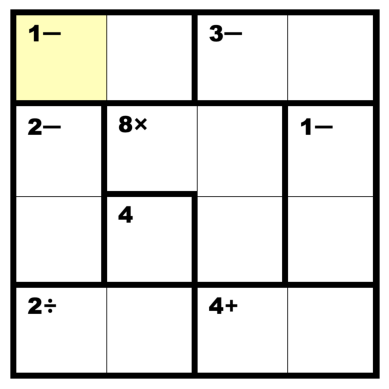

In [2]:
# Read the input image and perform cropping
og_img = cv2.imread('kenken.png')
gray = cv2.cvtColor(og_img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,150,255,0)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# assumes the square is the most significant contour on the page
outer_border = sorted(contours, key=cv2.contourArea)[-2]   
x, y, w, h = cv2.boundingRect(outer_border)
img = og_img[y:y+h, x:x+w]

imshow(img)

<hr>

<i>Determine the game size.</i>

If the determined game size is not accurate, manually set it.

In [3]:
# calculate game size from the contours
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,150,255,0)
new_contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
newimg = cv2.drawContours(img.copy(), new_contours, -1, (0,255,0), 3)

for contour in sorted(new_contours, key=cv2.contourArea, reverse=True):
    x, y, w, h = cv2.boundingRect(contour)
    ratio = len(img) // min(w, h)
    if ratio == 1:
        continue
    else:
        GAME_SIZE = ratio
        break

print(f"The game size is {GAME_SIZE}.")

# GAME_SIZE =    # MNAUALLY SET IT HERE

The game size is 4.


<hr>

<i>Find all the blocks in the image.</i>

After this step, the outputted image should have green outlines wherever the major blocks are.

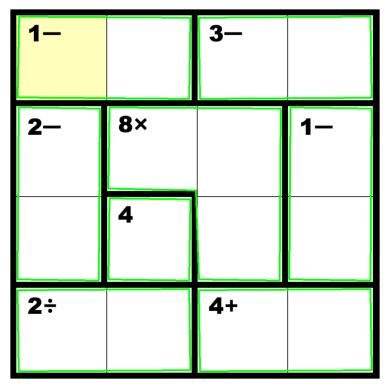

In [4]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, getblur(GAME_SIZE), 0)
ret, thresh = cv2.threshold(blur,150,255,0)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# get dark-squared contours
filtered = []; shapes = []
for contour in contours:
    epsilon = 0.02*cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    if len(approx) >= 4:
        x, y, w, h = cv2.boundingRect(contour)
        if min(w, h) > len(img) / 10:       # assures that no numbered contours are interpreted
            filtered.append(contour)
            shapes.append(approx)

# draw the contour on the input image
newimg = cv2.drawContours(img.copy(), shapes, -1, (0,255,0), 3)

# display the image with drawn contours and approximate contours
imshow(newimg)

<hr>

<i>Determine the operations within each square, preparing it for solving.</i>

If something is going wrong, check the printed result and assure it is consistent with the image.

In [5]:
relations = []
box_size = len(img) / GAME_SIZE 

def process(text: str):
    text = text.replace(' ', '')    # remove shapes
    text = text.lower()             # standardize style
    text = text.strip()             # remove any whitespace

    if [char for char in text if char not in SYMBOLS] == []:
        return None

    # undo 180-degree interpreted rotation by the OCR
    if text[0] in SYMBOLS:
        text = [*reversed(text)]
        for replacement in REPLACEMENT_PAIRS:
            for i, char in enumerate(text):
                if char in replacement:
                    text[i] = r1 if char != (r1:=(replacement[1])) else replacement[0]
        return "".join(text)
    
    return text

for approx in shapes:
    approx = list(map(lambda arr: list(map(lambda x: round(x/box_size), arr[0])), approx))
    points = list(map(lambda x: Point(*x), approx))
    x, y, w, h = cv2.boundingRect(np.array(approx))
    rel = []
    for xx in np.arange(start=x+0.5, stop=x+w+0.5, step=1):
        for yy in np.arange(start=y+0.5, stop=y+h+0.5, step=1):
            if checkInside(points, len(points), Point(xx, yy)):
                rel.append(Point(xx-0.5, yy-0.5))
    relations.append(rel)

operations = []
for i in range(len(relations)):
    rel = relations[i]
    operation = {
        "result": None,
        "operand": None,
        "squares": []
    }
    for point in rel:      # determine which point in the relation has the operation indicator
        y_lower, x_lower = max(int((point.y-0.1)*box_size), 0), max(int((point.x-0.1)*box_size), 0)
        y_upper, x_upper = int(y_lower+box_size*1.2), int(x_lower+box_size*1.2)
        cropped_img = img[y_lower:y_upper, x_lower:x_upper]
        if (text:=OCR.ocr(cropped_img, cls=True)) != [[]]:
            text = process(text[0][0][1][0])     # get prediction and process it
            if text == None:
                continue
            """ By this step, <text> should be a string like this: "17+", "14x", "3:", etc. """
            if "+" in text:
                operation["operand"] = Ops.ADDITION
                operation["result"] = int(text.replace("+", ""))
            elif ":" in text:
                operation["operand"] = Ops.DIVISION
                operation["result"] = int(text.replace(":", ""))
            elif "x" in text:
                operation["operand"] = Ops.MULTIPLICATION
                operation["result"] = int(text.replace("x", ""))
            elif any([s in text for s in ["-", "—", "_"]]):
                operation["operand"] = Ops.SUBTRACTION
                operation["result"] = int(re.sub(r"[\_\-\—]+", "", text))
            else:   # likely fully empty
                operation["result"] = int(text)
                match len(rel):
                    case 2: 
                        operation["operand"] = Ops.SUBTRACTION
                    case 1:
                        operation["operand"] = Ops.CONSTANT
                    case _:
                        raise Exception("Invalid pattern detected.")
            operation["squares"] = copy(rel)
            break
    if operation["operand"] != None:
        operations.append(operation) 

print(*operations, sep="\n")

{'result': 4, 'operand': '+', 'squares': [(2.0, 3.0), (3.0, 3.0)]}
{'result': 2, 'operand': '/', 'squares': [(0.0, 3.0), (1.0, 3.0)]}
{'result': 4, 'operand': '_', 'squares': [(1.0, 2.0)]}
{'result': 1, 'operand': '-', 'squares': [(3.0, 1.0), (3.0, 2.0)]}
{'result': 8, 'operand': '*', 'squares': [(1.0, 1.0), (2.0, 1.0), (2.0, 2.0)]}
{'result': 2, 'operand': '-', 'squares': [(0.0, 1.0), (0.0, 2.0)]}
{'result': 3, 'operand': '-', 'squares': [(2.0, 0.0), (3.0, 0.0)]}
{'result': 1, 'operand': '-', 'squares': [(0.0, 0.0), (1.0, 0.0)]}


<hr>

<i>Solve the puzzle.</i>

In [17]:
# board manipulations and checks
def illegal_col(board, col_num):
    return len(a:=([v for i in range(GAME_SIZE) if (v:=board[i][col_num]) != 0])) != len(set(a))
def illegal_row(board, row_num):
    return len((a:=[v for v in board[row_num] if v != 0])) != len(set(a))
def mod_board(board, num, val):
    board[num//GAME_SIZE][num%GAME_SIZE] = val
def get_board(board, num):
    return board[num//GAME_SIZE][num%GAME_SIZE]

def get_possible_values(operation):
    result = operation["result"]
    match operation["operand"]:
        case Ops.SUBTRACTION:
            output = list()
            for i in range(result+1, GAME_SIZE+1):
                output.extend([i, i-result])
            return set(output)
        case Ops.DIVISION:
            output = list()
            for i in range(1, GAME_SIZE // result + 1):
                if i*result <= GAME_SIZE:
                    output.extend([i, i*result])
            return set(output)
        case Ops.MULTIPLICATION:
            return {i for i in range(1, GAME_SIZE+1) if result % i == 0}
        case Ops.ADDITION:
            return {*range(1, min(GAME_SIZE, result-len(operation["squares"])+1)+1)}
        
def check_possible(board, iter, value):
    global rels
    try:
        mod_board(board, iter, value)
        if illegal_col(board, iter%GAME_SIZE):
            return False
        elif illegal_row(board, iter//GAME_SIZE):
            return False
        operation = get_board(rels, iter)
        result = operation["result"]
        match operation["operand"]:
            case Ops.SUBTRACTION:
                iters = [point.get_iter(GAME_SIZE) for point in operation["squares"]]
                v1, v2 = [get_board(board, iter) for iter in iters]
                if v1 == 0 or v2 == 0:
                    return True
                return abs(v2 - v1) == result
            case Ops.ADDITION:
                iters = [point.get_iter(GAME_SIZE) for point in operation["squares"]]
                values = [get_board(board, iter) for iter in iters]
                if any([val == 0 for val in values]):
                    return sum(values) < result   # not possible if sum is already greater than or equal to
                return sum(values) == result
            case Ops.DIVISION:
                iters = [point.get_iter(GAME_SIZE) for point in operation["squares"]]
                v1, v2 = [get_board(board, iter) for iter in iters]
                if v1 == 0 or v2 == 0:
                    return True
                return round(max(v1, v2) / min(v1, v2), 2) == result
            case Ops.MULTIPLICATION:
                iters = [point.get_iter(GAME_SIZE) for point in operation["squares"]]
                values = [get_board(board, iter) for iter in iters]
                if any([val == 0 for val in values]):
                    return np.prod([val for val in values if val != 0]) <= result    
                return np.prod(values) == result
    finally:
        mod_board(board, iter, 0)

# make blank arrays for everything
board = [[0 for _ in range(GAME_SIZE)] for _ in range(GAME_SIZE)]
possible_values = deepcopy(board)
rels = deepcopy(board)

# fill arrays
for op in operations:
    if op["operand"] == Ops.CONSTANT:
        point = op["squares"][0]
        mod_board(board, point.get_iter(GAME_SIZE), op["result"])
        continue
    for point in op["squares"]:
        iter = point.get_iter(GAME_SIZE)
        mod_board(possible_values, iter, {*range(1, GAME_SIZE+1)}) #get_possible_values(op))
        mod_board(rels, iter, deepcopy(op))

def solve(board, iter):
    if iter >= GAME_SIZE**2:
        raise Exception("Catch me! I'm done!")
    if get_board(board, iter) != 0:
        solve(board, iter+1); return
    for value in range(1, GAME_SIZE+1):
        if value not in get_board(possible_values, iter):
            continue
        elif check_possible(board, iter, value):
            mod_board(board, iter, value)
            solve(board, iter+1)
    mod_board(board, iter, 0)       # reset if unsuccessful

try:
    solve(board, 0)

    # if made it through this point its not solved
    solved = False
    print("Coudln't solve board.")
except:
    print(board)


[[2, 3, 1, 4], [3, 1, 4, 2], [1, 4, 2, 3], [4, 2, 3, 1]]
